In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [40]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [41]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [42]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [43]:
# модель
# model = MLP(20, 10)

# Критерий/ функция потерь
criterion = torch.nn.BCELoss()

 # Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS
optimizer = optim.Adam(model.parameters())

In [68]:
def TrainModel(optimizer, model, n_epochs = 200, batch_size = 8):
    # Критерий/ функция потерь
    criterion = torch.nn.BCELoss()

    sns.set()
    
    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
            def closure():
                #  your code here 
                optimizer.zero_grad()

                # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x_train[indices], y_train[indices]

                # Считаем лосс и добавляем его значение в массив
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)

                loss_array.append(loss.item())
                loss.backward()
                return loss


            #  your code here 
            optimizer.step(closure)


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

        display.clear_output(wait=True)
        plt.figure(figsize =(12, 7))
        plt.plot(epoch_array, label ="TRAIN")
        plt.plot(epoch_test_array, label ="TEST")
        plt.legend(loc="best", fontsize=20)
        plt.show()

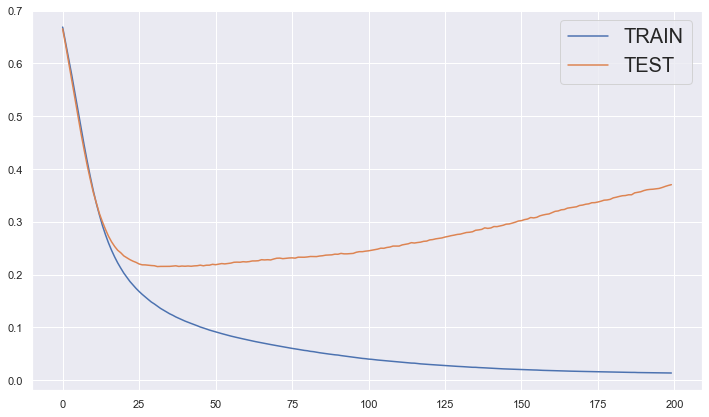

In [65]:
model = MLP(20, 10)
TrainModel(optim.Adam(model.parameters()), model)

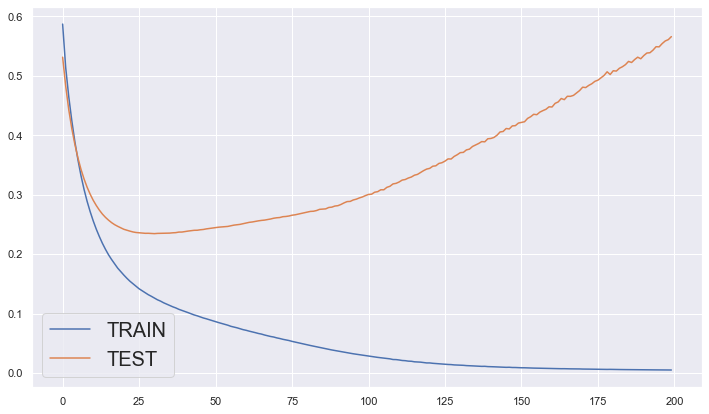

In [66]:
model = MLP(20, 10)
TrainModel(optim.RMSprop(model.parameters(), lr= 0.001), model)

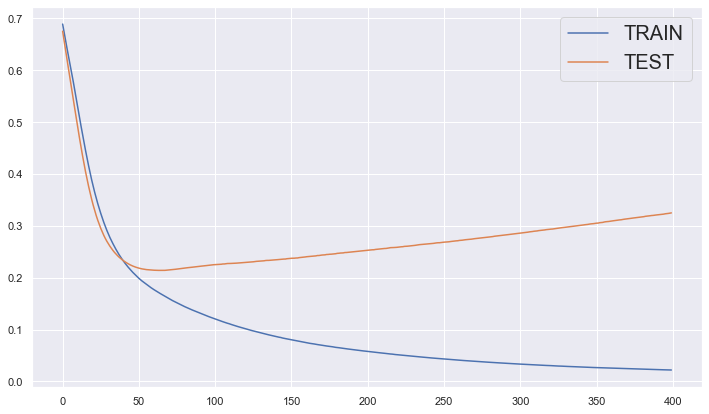

In [70]:
model = MLP(20, 10)
TrainModel(optim.SGD(model.parameters(), lr=0.01), model, 400)

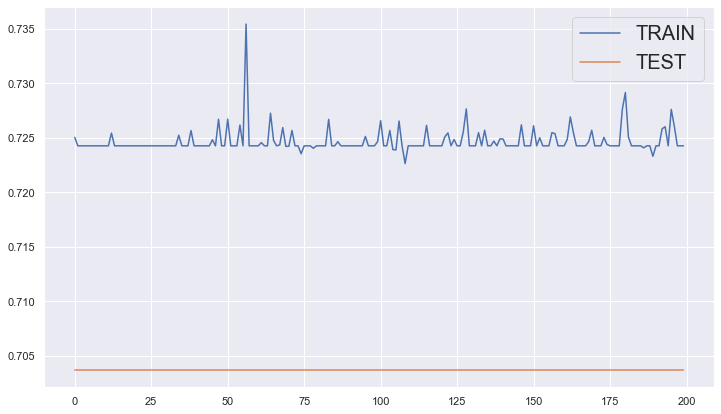

In [64]:
model = MLP(20, 10)
TrainModel(optim.LBFGS(model.parameters(), lr=0.001, history_size=10, max_iter=30), model)

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

Мы видим, что всем оптимизаторам (кроме LBFGS с которой что то не так, и в дальнейшем мы проводим рассуждения для всех оптимизаторов кроме него) свойственно переобучение, а именно сперва с ростом кол-ва эпох ошибка на тестовой выборке падает, достигает минимума, а затем при большом кол-ве эпох ошибка на тестовой выборке начинает возрастать, хотя на обучающей выборке она все уменьшается. Так же стоит отметить, что не редок случай, когда ошибка на тестовой выборке меньше, чем на обучающеся, но это свойственно скорее случаям с малый кол-вом эпох и большой ошибкой. При приближении к минимуму ошибки обычно на тестовой выборке ошибка больше, чем на обучающей.

Наименьшую ошибку дает оптимизатор SGD. При этом он достиг минимума ошибки на тестовой выборке (min loss около 0.18) при кол-ве эпох примерно 65, в то время как другие оптимизаторы справились раньше - при примерно 25. При этом их ошибки примерно равны между собой (у Adam min loss около 0.22, у RMSprop около 0.24).

Отметим также, что переобучение у данных оптимизаторах в нашем случае сперва происходило медленно, а затем ускорялось. У RMSprop переобучение происходило гораздо быстрее, чем у остальных оптимизаторов.